# Imports

In [1]:
%%capture
!chmod -R 777 ../

In [3]:
# System and Path Operations
import sys
import os
from pathlib import Path
from glob import glob
import datetime

# Custom Module Imports
sys.path.insert(0, '../')
from src.config import *
from src.utils import *
from src.models_arch import *
from src.models_utils import *
from src.prepare_data import *

# Setting seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Deep Learning and Computer Vision Libraries
from ultralytics import YOLO
import torch
from PIL import Image
import cv2
import numpy as np
from rasterio import features
import matplotlib.pyplot as plt
%matplotlib inline


# Data preparation

In [4]:
def save_images_and_masks(images, masks, root_dir='test'):
    # Ensure root_dir exists
    os.makedirs(root_dir, exist_ok=True)

    # Create directories for images and masks
    img_dir = os.path.join(root_dir, 'images')
    mask_dir = os.path.join(root_dir, 'masks')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    # Loop through all the images and masks and save them
    for i in range(images.shape[0]):
        # Convert RGB image to BGR
        bgr_img = cv2.cvtColor((images[i] * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        img = Image.fromarray(bgr_img)
        img.save(os.path.join(img_dir, f'img_{i:04d}.png'))

        mask = Image.fromarray((masks[i, :, :, 0] * 255).astype(np.uint8))
        mask.save(os.path.join(mask_dir, f'img_{i:04d}.png'))


def display_image(image):
    cv2.imshow('Image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def read_annotation(annotation_path, H, W):
    # Read the annotation file or handle glob pattern
    if '*' in annotation_path:
        annotation_files = sorted(glob.glob(annotation_path))
    else:
        annotation_files = [annotation_path]

    masks = []

    # Process each annotation file
    for ann_file in annotation_files:
        # Initialize an empty mask
        mask = np.zeros((H, W), dtype=np.uint8)

        # Read the annotation file
        with open(ann_file, 'r') as f:
            lines = f.readlines()

        # Create a list to hold all polygons
        polygons = []

        # Process each line
        for line in lines:
            # Remove the leading '0 ' and the trailing '\n', then split the line into coordinates
            coords = line[2:-1].split(' ')

            # Process the coordinates in pairs and add them to the polygon
            polygon = [(float(coords[i]) * W, float(coords[i+1]) * H) for i in range(0, len(coords), 2)]
            polygons.append(polygon)

        # Draw the polygons on the mask
        for polygon in polygons:
            # The fillPoly function expects an array of polygons, where each polygon is an array of points,
            # but each point needs to be a 1-by-2 array, hence the extra wrapping with np.array and the reshaping
            cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32).reshape(-1, 1, 2)], 255)
        
        mask = np.where(mask > 0, 1, 0)
        masks.append(mask)

    return np.array(masks)


def create_label(input_dir, output_dir):
    for j in os.listdir(input_dir):
        image_path = os.path.join(input_dir, j)
        # load the binary mask and get its contours
        mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

        H, W = mask.shape
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # convert the contours to polygons
        polygons = []
        for cnt in contours:
            # if cv2.contourArea(cnt) > 200:
            #     polygon = []
            #     for point in cnt:
            #         x, y = point[0]
            #         polygon.append(x / W)
            #         polygon.append(y / H)
            #     polygons.append(polygon)
            
            if cv2.contourArea(cnt) > 50:
                polygon = []
                for point in cnt:
                    x, y = point[0]
                    polygon.append(x / W)
                    polygon.append(y / H)
                polygons.append(polygon)

        # print the polygons
        with open('{}.txt'.format(os.path.join(output_dir, j)[:-4]), 'w') as f:
            for polygon in polygons:
                for p_, p in enumerate(polygon):
                    if p_ == len(polygon) - 1:
                        f.write('{}\n'.format(p))
                    elif p_ == 0:
                        f.write('0 {} '.format(p))
                    else:
                        f.write('{} '.format(p))

            f.close()

In [5]:
dataset = 'SPARCS'
# dataset = 'Biome'

In [6]:
# Preprocessing the data

if dataset == 'SPARCS':
    images, masks = get_SPARCS('train', only_rgb=True)
    save_images_and_masks(images, masks, Path(yolo_data_dir, 'train'))

    images, masks = get_SPARCS('valid', only_rgb=True)
    save_images_and_masks(images, masks, Path(yolo_data_dir, 'val'))

    images, masks = get_SPARCS('test', only_rgb=True)
    save_images_and_masks(images, masks, Path(yolo_data_dir, 'test'))
elif dataset == 'Biome':
    images, masks = get_biome8('train', only_rgb=True)
    save_images_and_masks(images, masks, Path(yolo_data_dir, 'train'))

    images, masks = get_biome8('valid', only_rgb=True)
    save_images_and_masks(images, masks, Path(yolo_data_dir, 'val'))

    images, masks = get_biome8('test', only_rgb=True)
    save_images_and_masks(images, masks, Path(yolo_data_dir, 'test'))


In [7]:
os.listdir(yolo_data_dir)

['val', 'train', 'test']

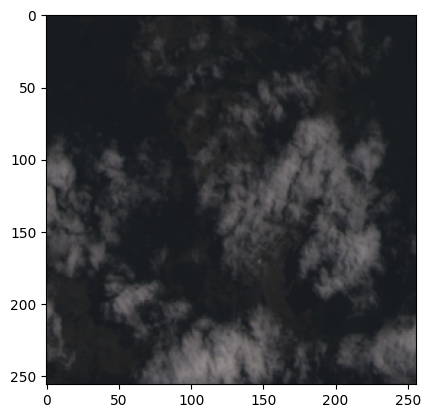

In [16]:
# Check the images
image_path = str(data_path / 'YOLO/test/images/img_0016.png')  

image = cv2.imread(image_path)

if image is not None:
    plt.imshow(image)
else:
    print("Image not found or could not be loaded.")

In [9]:
for split_dir in os.listdir(yolo_data_dir):
    input_dir = os.path.join(yolo_data_dir, split_dir, 'masks')
    output_dir = os.path.join(yolo_data_dir, split_dir, 'labels')
    os.makedirs(output_dir, exist_ok=True)
    create_label(input_dir, output_dir)
    
    # Check if the directory exists
    if os.path.exists(input_dir):
        # Remove the directory and all its contents
        shutil.rmtree(input_dir)
    else:
        print("The directory does not exist")

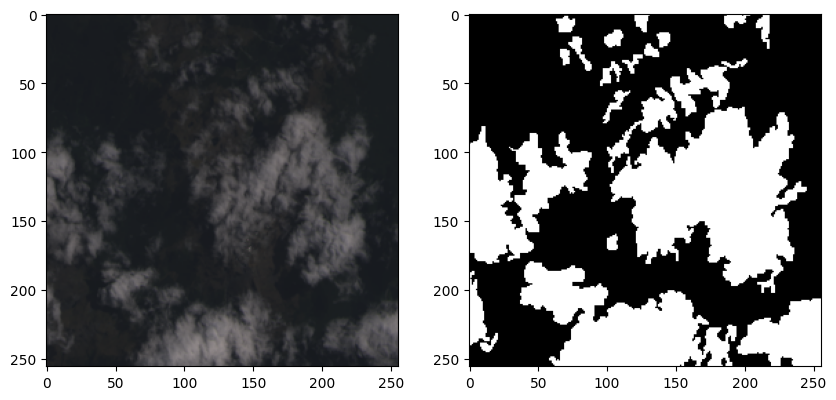

In [15]:
# Check the labels and annotations

im = cv2.imread(str(data_path / 'YOLO/test/images/img_0016.png'))
a_mask = read_annotation(str(data_path / 'YOLO/test/labels/img_0016.txt'), 256, 256)

# Subplot of the thow masks
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.subplot(1, 2, 2)
plt.imshow(a_mask[0], cmap='gray')    

# setup

In [10]:
yaml_content = f'''
path: {yolo_data_dir}/
train: train/images
val: val/images
test: test/images

#Classes
nc: 1 

#classes names
names: ['cloud']
'''

config_path = Path(notebooks_path, 'my-yolo-seg.yaml')

with config_path.open('w') as f:
    f.write(yaml_content)

# Run model

In [11]:
model = YOLO('yolov8n-seg.yaml').load('yolov8x-seg.pt')  # build from YAML and transfer weights
# model = YOLO('yolov8n-seg.yaml')

name = f'yolov8n_pre_epochs300_batch16_{dataset}'
name


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

'yolov8n_pre_epochs300_batch16_Biome'

In [12]:
results = model.train(
        batch=16,
        device=[0],
        data="my-yolo-seg.yaml",
        epochs=300,
        imgsz=256,
        name=name,
    )

New https://pypi.org/project/ultralytics/8.0.163 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.142 🚀 Python-3.9.17 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=my-yolo-seg.yaml, epochs=300, patience=50, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov8n_pre_epochs300_batch16_Biome, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=F

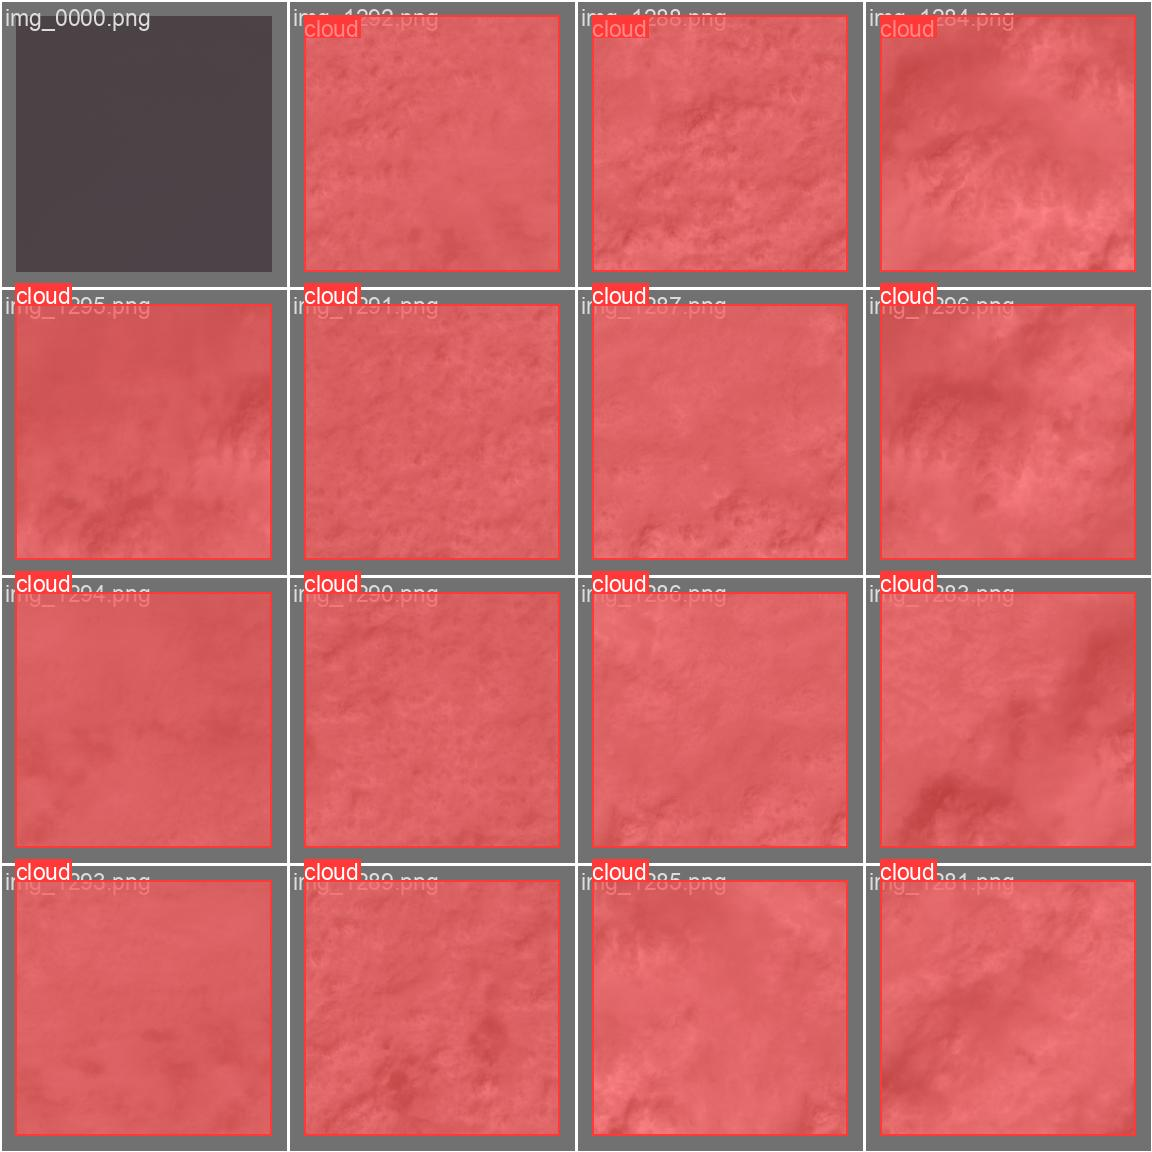

In [14]:
from IPython.display import Image as show_image
show_image(filename=notebooks_path / f"runs/segment/{name}/val_batch0_labels.jpg")

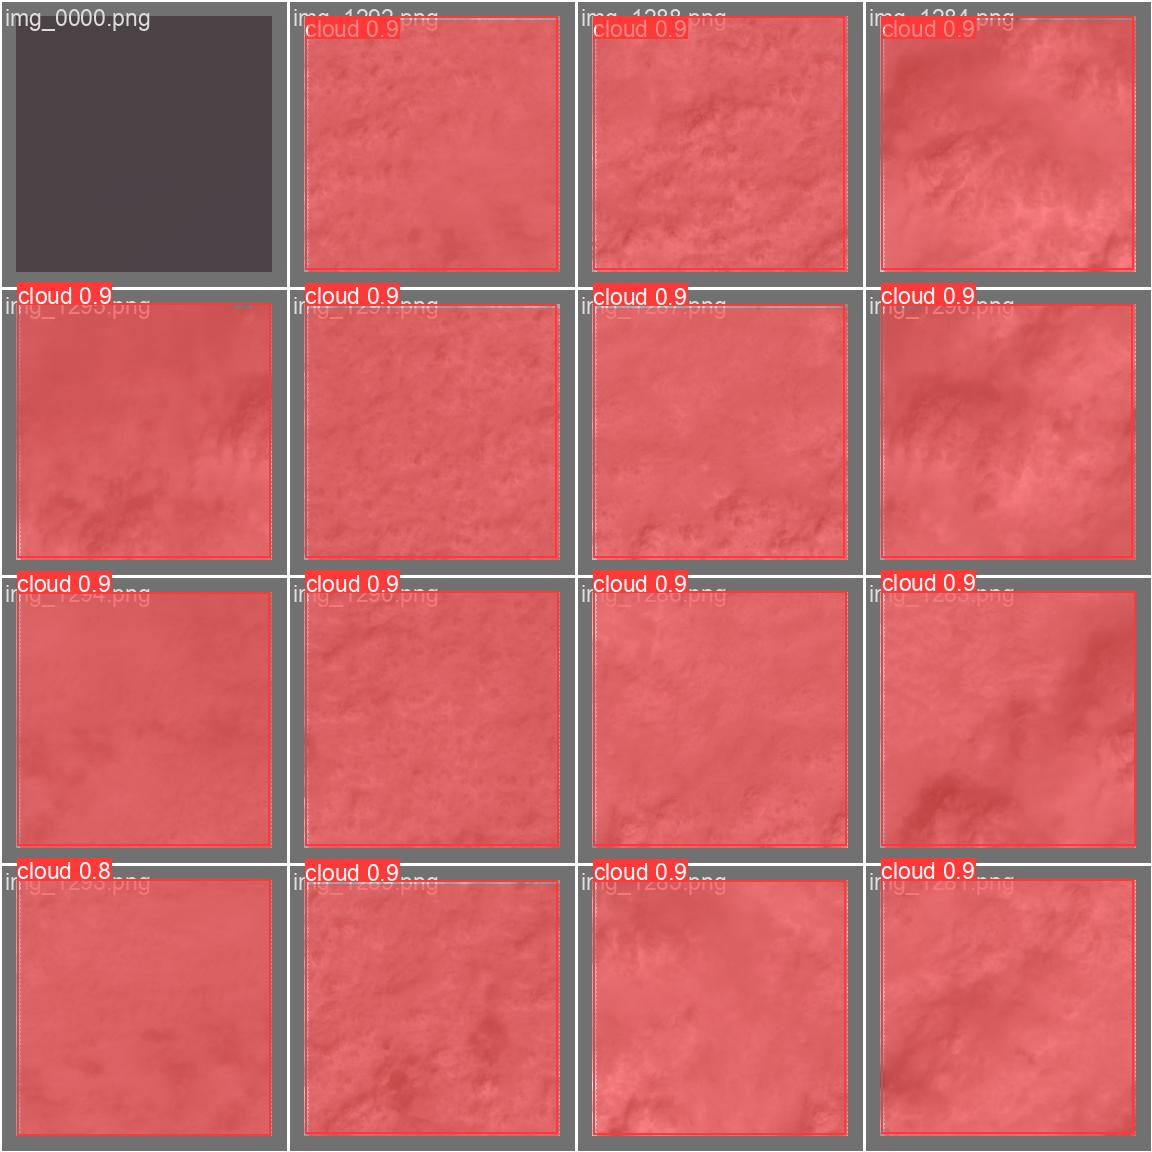

In [15]:
show_image(filename=notebooks_path / f"runs/segment/{name}/val_batch0_pred.jpg")

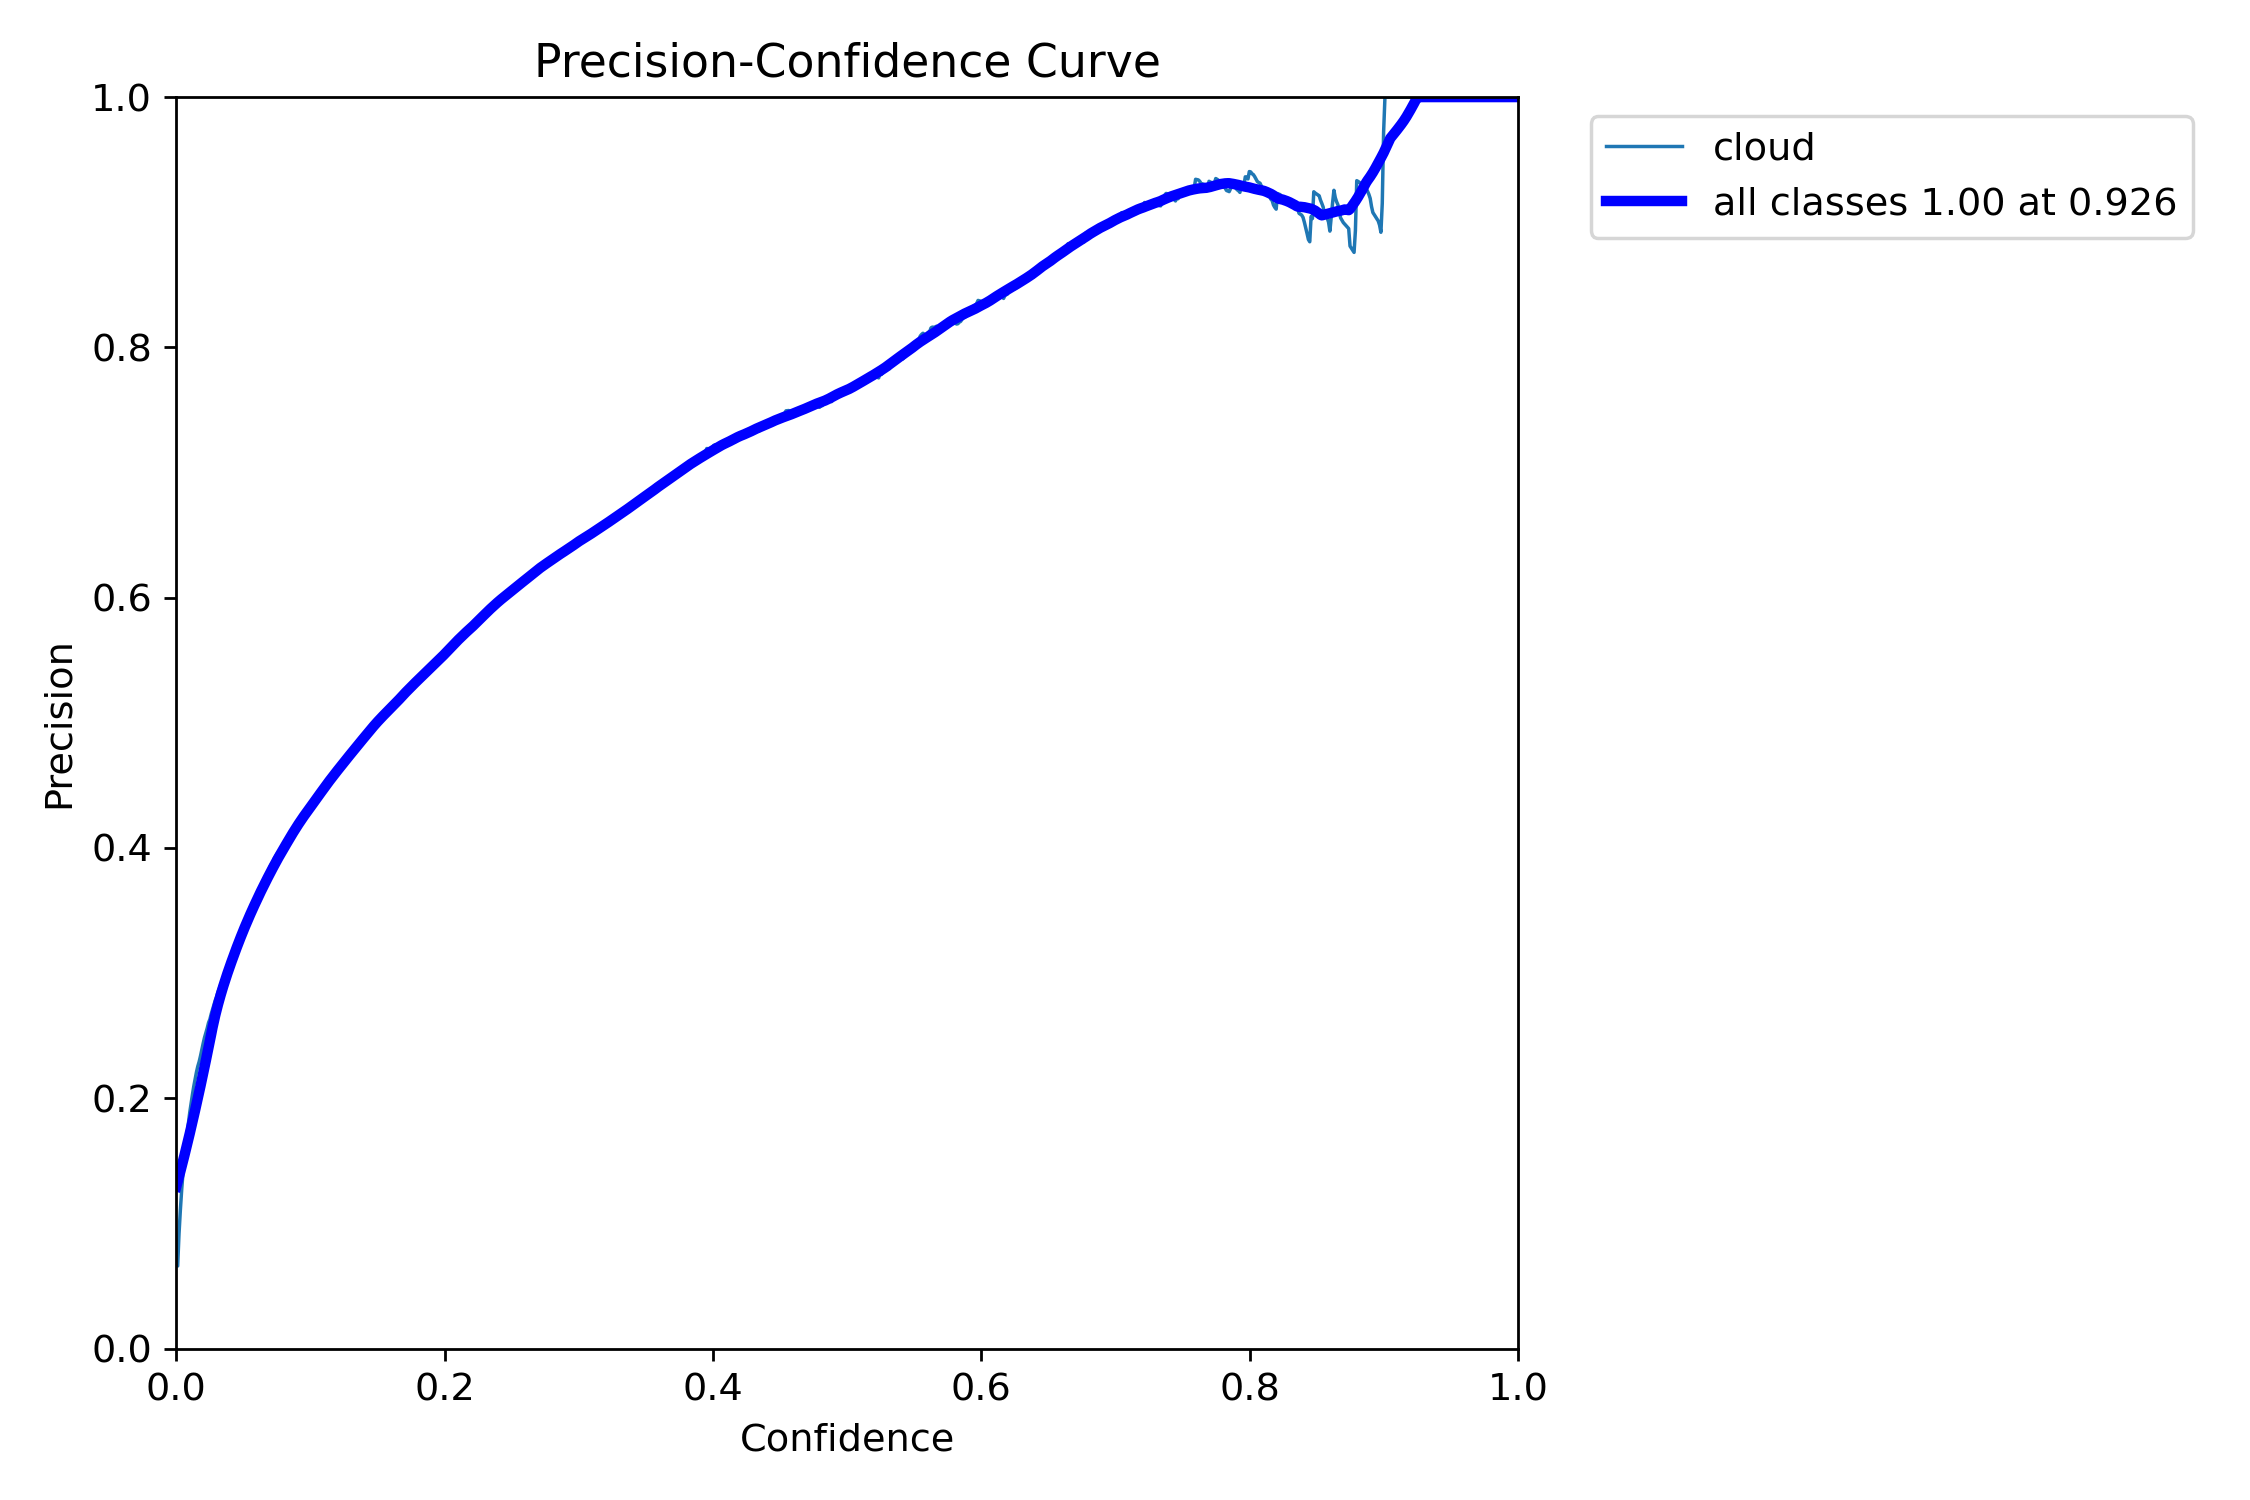

In [ ]:
show_image(filename=notebooks_path / f"runs/segment/{name}/MaskP_curve.png")

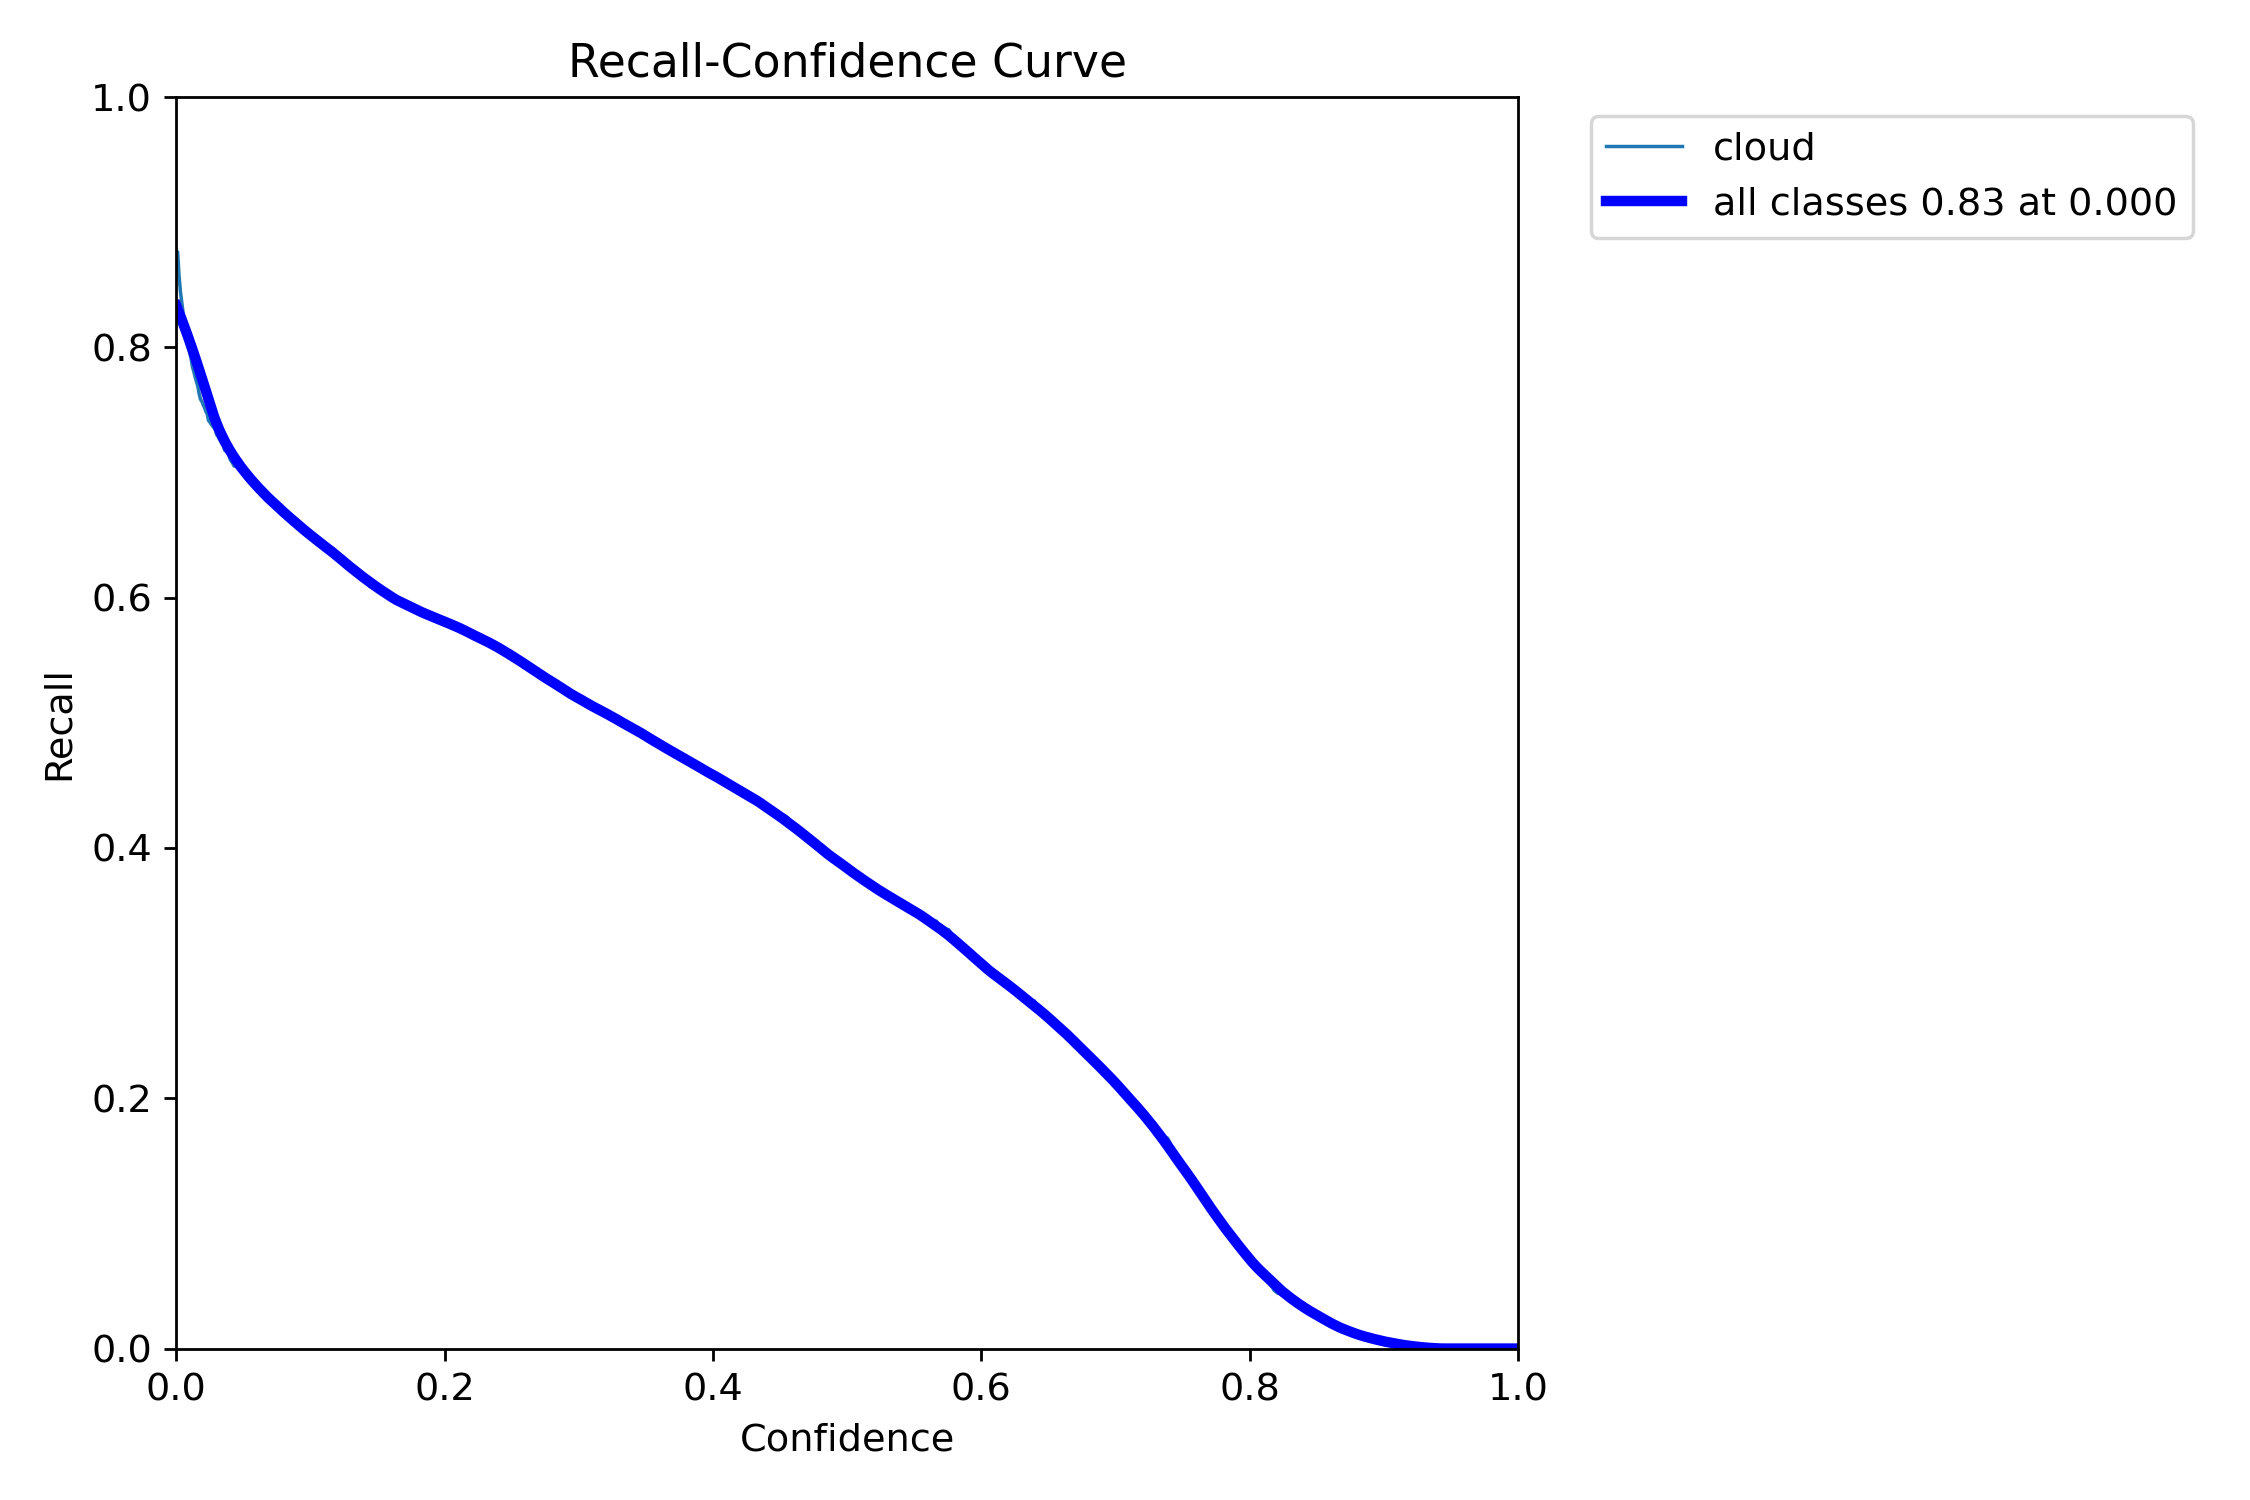

In [ ]:
show_image(filename=notebooks_path / f"runs/segment/{name}/MaskR_curve.png")

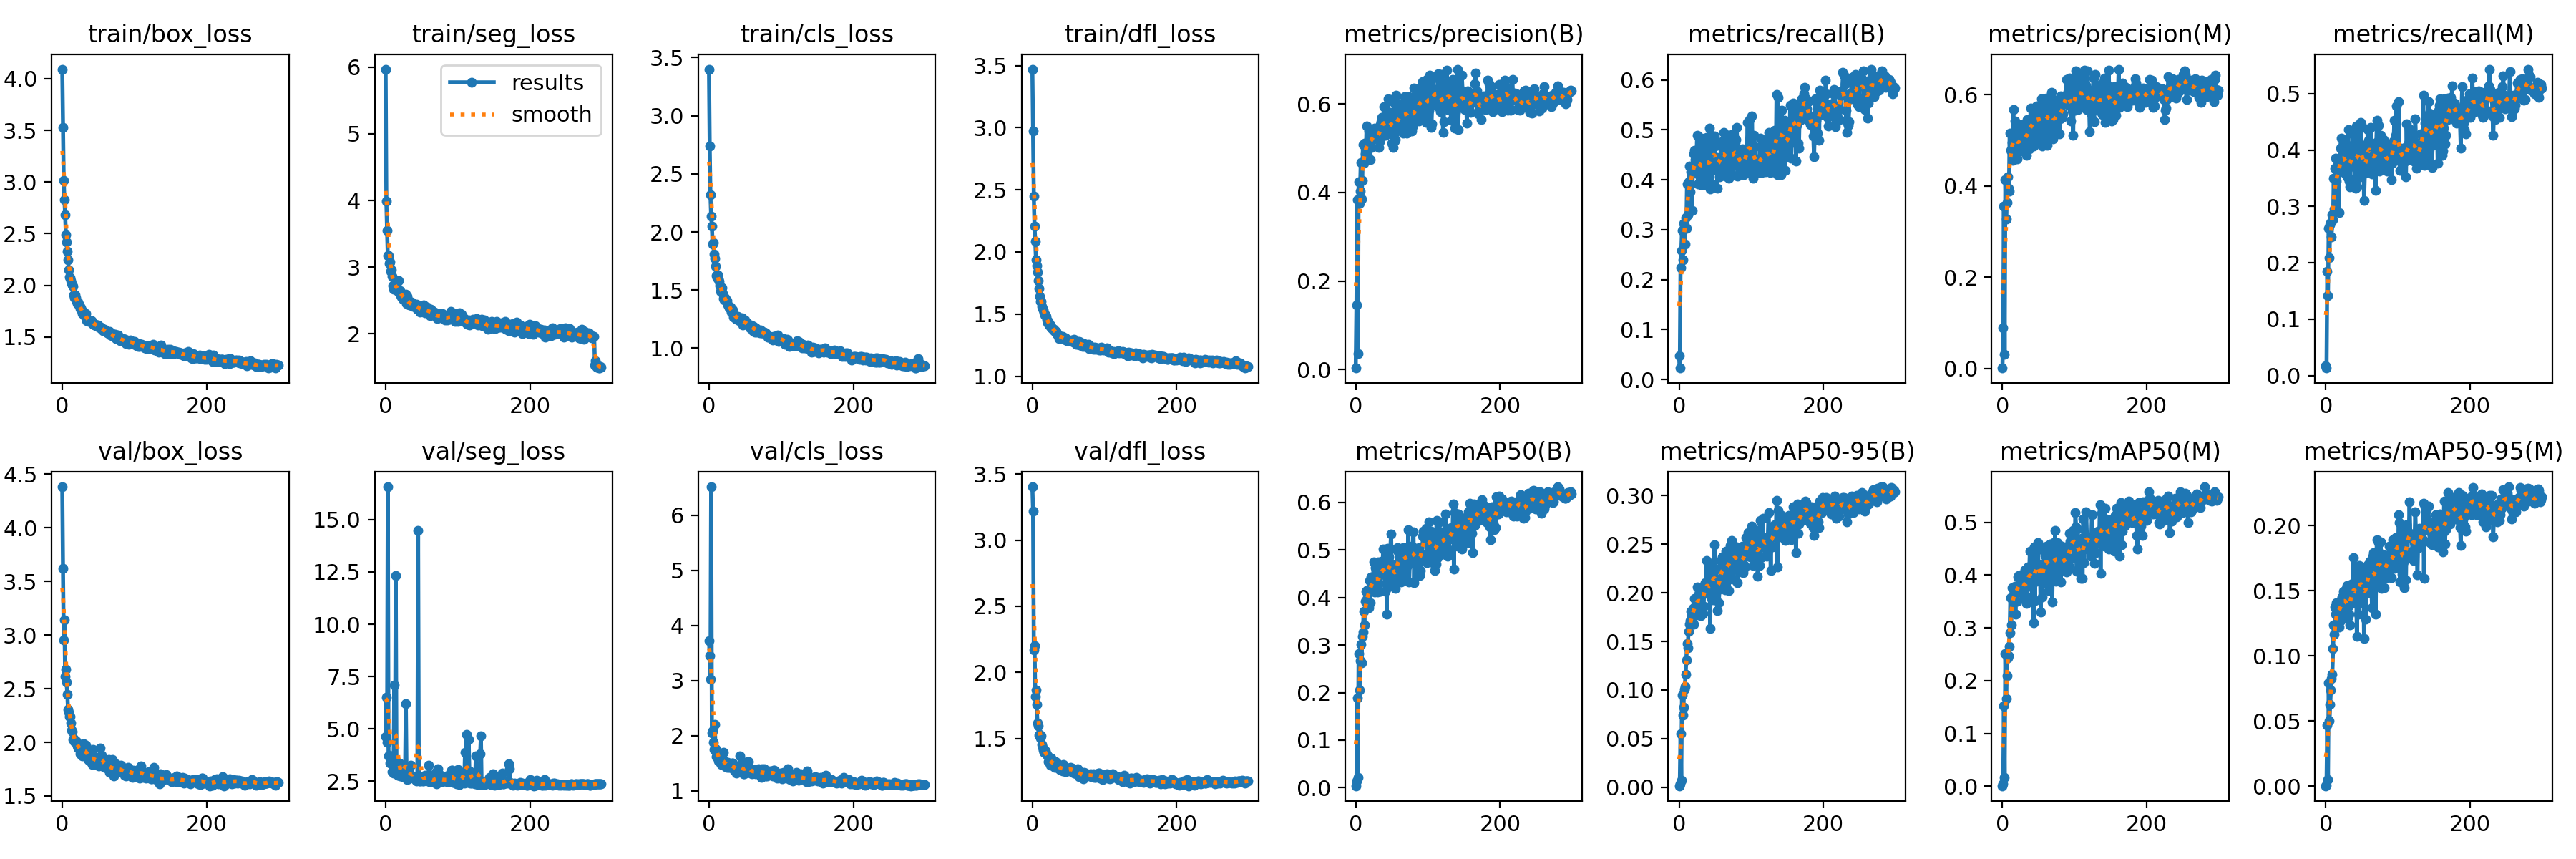

In [ ]:
show_image(filename=notebooks_path / f"runs/segment/{name}/results.png")
